# Obtain regulons based on gene expression similarity

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0,module_path)

import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
alt.renderers.enable('notebook')

from correlation_enrichment.library import SimilarityCalculator
from library_regulons import *


In [2]:
dataPath=module_path+'/data_expression/'
genes = pd.read_csv(dataPath + 'mergedGenes_RPKUM.tsv', sep='\t', index_col=0)
conditions = pd.read_csv(dataPath + 'conditions_mergedGenes.tsv', sep='\t', index_col=None)

## Set parameters

### Compare parameters for similarity calculation (expression scaling, way of combining samples)

In [3]:
def compare_conditions(genes,conditions,  neighbours_n, inverse, scale, use_log, thresholds, filter_column, filter_column_values_sub,
                       filter_column_values_test, batch_column=None):
    """
    Evaluates pattern similarity calculation preprocessing and parameters based on difference between subset and test set.
    Computes MSE from differences between similarities of subset gene pairs and corresponding test gene pairs.
    :param genes: data frame with gene expression data, genes in rows, measurments in columns, dimension G*M
    :param conditions: data frame with conditions for genes subseting, measurments in rows,rows should have same order as
        genes table columns, dimensions M*D (D are description types)
    :param neighbours_n: N of calculated neighbours for each gene
    :param inverse: find neighbours with opposite profile
    :param scale: 'minmax' (from 0 to 1) or 'mean0std1' (to mean 0 and std 1)
    :param use_log: Log transform expression values before scaling
    :param thresholds: filter out any result with similarity below threshold, do for each threshold
    :param filter_column: On which column of conditions should genes be subset for separation in subset and test set
    :param filter_column_values_sub: Values of filter_column to use for subset genes
    :param filter_column_values_test:Values of filter_column to use for test genes
    :param batch_column: Should batches be used based on some column of conditions
    :return: Dictionary with parameters and results, description as key, result/parameter setting as value
    """
    # Prepare data
    if not batch_column:
        batches = None
    else:
        batches=list((conditions[conditions[filter_column].isin(filter_column_values_sub)].loc[:, batch_column]))
    genes_sub = genes.T[list(conditions[filter_column].isin(filter_column_values_sub))].T
    genes_test = genes.T[list(conditions[filter_column].isin(filter_column_values_test))].T

    neighbour_calculator = NeighbourCalculator(genes_sub)
    test_index, test_query = NeighbourCalculator.get_index_query(genes_test, inverse=inverse, scale=scale, log=use_log)
    gene_names = list(genes_test.index)
    
    # Is similarity matrix expected to be simetric or not
    both_directions = False
    if inverse and (scale == 'minmax'):
        both_directions = True
    
    # Calculate neighbours
    result = neighbour_calculator.neighbours(neighbours_n, inverse=inverse, scale=scale, log=use_log,
                                             batches=batches)

    # Filter neighbours on similarity
    data_summary=[]
    for threshold in thresholds:
        if batches != None:
            result_filtered = neighbour_calculator.merge_results(result.values(), threshold, len(set(batches)))
        else:
            result_filtered = NeighbourCalculator.filter_similarities(result, threshold)

        # Calculate MSE for each gene pair -
        # compare similarity from gene subset to similarity of the gene pair in gene test set
        sq_errors = []
        for pair, similarity in result_filtered.items():
            gene1 = pair[0]
            gene2 = pair[1]

            index1=gene_names.index(gene1)
            index2 = gene_names.index(gene2)
            similarity_test=calc_cosine(test_index,test_query,index1,index2,sim_dist=True,both_directions=both_directions)
            
            se = (similarity - similarity_test) ** 2
            # Happens if at least one vector has all 0 values
            if not np.isnan(se):
                sq_errors.append(se)
        if len(sq_errors)>0:
            mse=round(mean(sq_errors),5)
        else:
            mse=float('NaN')
        n_genes=len(set(gene for pair in result_filtered.keys() for gene in pair))
        data_summary.append( {'N neighbours': neighbours_n, 'inverse': inverse, 'use_log': use_log, 'scale': scale,
                'threshold': threshold, 'batches': batch_column, 'MSE': mse,
                'N pairs': len(result_filtered),'N genes':n_genes})
    return data_summary

In [4]:
#Make table of results for different condition settings
results=[]
#Which parameters to try
thresholds=[0.95]
for scale in ['minmax','mean0std1']:
    for use_log in [True,False]:
            for inverse in [False,True]:
                for n_neighbours in [30]:
                    result = compare_conditions(genes, conditions,#Data
                                        # Parameters
                                        neighbours_n=n_neighbours, inverse=inverse, scale=scale, use_log=use_log,
                                        thresholds=thresholds, 
                                        filter_column='Replicate',
                                        #For subset genes
                                        filter_column_values_sub=['comH_r1', 'cudA_r2', 'gbfA_r1', 'mybBGFP_bio1',
                                                                  'pkaR_bio1'],
                                        #For test genes
                                        filter_column_values_test=['AX4_bio1'], 
                                                
                                        batch_column=None)
                    for res in result:
                        results.append(res)
data_summary_params=pd.DataFrame(results)

/home/karin/Documents/git/orange3venv/lib/python3.6/site-packages/numba/ir_utils.py:1959: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'forest' of function 'initialise_search'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../orange3venv/lib/python3.6/site-packages/pynndescent/pynndescent_.py", line 72:
@numba.njit()
def initialise_search(
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/home/karin/Documents/git/baylor-dicty/correlation_enrichment/library.py:235: RuntimeWarning: invalid value encountered in double_scalars
  return np.inner(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))
/home/karin/Documents/git/baylor-dicty/correlation_enrichment/library.py:235: RuntimeWarning: invalid value encountered in double_scalars
  return np.inner(vector

In [5]:
data_summary_params.sort_values(by='MSE')


,N neighbours,inverse,use_log,scale,threshold,batches,MSE,N pairs,N genes
4,30,False,True,mean0std1,0.95,None,0.00884,6217,1615
0,30,False,True,minmax,0.95,None,0.00886,191352,9427
2,30,False,False,minmax,0.95,None,0.01616,57921,6958
1,30,True,True,minmax,0.95,None,0.02773,144097,9608
3,30,True,False,minmax,0.95,None,0.06865,69003,6809
6,30,False,False,mean0std1,0.95,None,0.10903,14100,2340
5,30,True,True,mean0std1,0.95,None,NaN,0,0
7,30,True,False,mean0std1,0.95,None,NaN,0,0


In [6]:
#Compare filtering thresholds
thresholds=[0.96,0.97,0.98,0.9825,0.985,0.9875,0.99,0.995,0.999,0.9995]
result = compare_conditions(genes, conditions,#Data
                                        # Parameters
                                        neighbours_n=300, inverse=False, scale='minmax', use_log=True,
                                        thresholds=thresholds, 
                                        filter_column='Replicate',
                                        #For subset genes
                                        filter_column_values_sub=['comH_r1', 'cudA_r2', 'gbfA_r1', 'mybBGFP_bio1',
                                                                  'pkaR_bio1'],
                                        #For test genes
                                        filter_column_values_test=['AX4_bio1'], 
                                                
                                        batch_column=None)

data_summary_thresholds=pd.DataFrame(result)

/home/karin/Documents/git/baylor-dicty/correlation_enrichment/library.py:235: RuntimeWarning: invalid value encountered in double_scalars
  return np.inner(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))


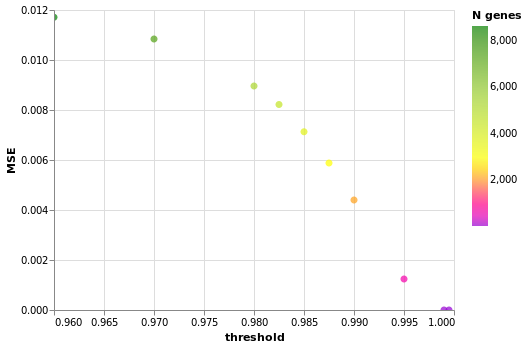

In [7]:
alt.Chart(data_summary_thresholds).mark_circle().encode(alt.X('threshold', scale=alt.Scale(zero=False)), 
                                             alt.Y('MSE', scale=alt.Scale(zero=False)),
                                             color=alt.Color('N genes', scale=
                                             alt.Scale(range=['darkviolet', 'yellow', 'yellowgreen', 'green']))
                                             ).configure_circle(size=50).interactive()

In [8]:
data_summary_thresholds

,N neighbours,inverse,use_log,scale,threshold,batches,MSE,N pairs,N genes
0,300,False,True,minmax,0.9600,None,0.01171,902026,8646
1,300,False,True,minmax,0.9700,None,0.01084,554577,7378
2,300,False,True,minmax,0.9800,None,0.00896,235707,5241
3,300,False,True,minmax,0.9825,None,0.00822,164927,4526
4,300,False,True,minmax,0.9850,None,0.00713,104686,3698
5,300,False,True,minmax,0.9875,None,0.00588,57911,2916
6,300,False,True,minmax,0.9900,None,0.00440,27422,2112
7,300,False,True,minmax,0.9950,None,0.00124,2841,643
8,300,False,True,minmax,0.9990,None,0.00000,63,53
9,300,False,True,minmax,0.9995,None,0.00000,48,41


#### Results summary
Sample: comH_r1, cudA_r2, gbfA_r1,mybBGBF_bio1,pkaR_bio1 and test sample: AX4_bio1; not inverse: threshold 0.95; neighbours 30

Comparison of scaling parameters:
minmax, no log: MSE 0.01615798890022193, filtered N: 57921
minmax, log: MSE 0.008855992300398607, filtered: 191347
mean0std1, no log: MSE 0.10903301209390322, filtered: 14100
mean0std1, log: MSE 0.008840844803079855, filtered: 6217
mean0std1, log, threshold 0.935: MSE 0.008617332426242763, filtered: 14239
Log on mean0std1 does not seem to perform better because of lesser number of retained pairs (eg. possibly more correlated ones, as shown when lowering filtering threshold for log based calculations

Compare MSE at different thresholds, minmax, log, not inverse, 300 neighbours, no batches
threshold: 0.99 MSE: 0.004401159883607221 N: 27422,
threshold: 0.98 MSE: 0.008960403278511933 N: 235707,
threshold: 0.97 MSE: 0.010837772836915213 N: 554577,
threshold: 0.95 MSE: 0.012256426645819427 N: 1246669,
threshold: 0.93 MSE: 0.012841511138263213 N: 1788086,
threshold: 0.91 MSE: 0.013112523538440932 N: 2091354

Use of batches by replicate:
minmax, log, batches: MSE 0.0005413249414331597, filtered: 243
Try to lower threshold for merging to obtain similar number of results: However, even when lowering the threshold substantially (eg. to max of lowest similarity of individual strains - as pair must be present in all strains) the number of filtered pairs remained at 270

Compare result by using batches on samples or strains
Sample strains: comH, cudA, gbfA, mybBGBF, pkaR (each 2 replicates) and test sample: AX4_bio1; not inverse, threshold 0.95, neighbours 30, minmax, log: 
By strain: 0.0006956959575191145 N: 559, when lowering merging threshold to max of any result's min similarity there is 762 pairs
By replicate: 6.592793901930816e-05 N: 41, when lowering the merging threshold as above got to 54 pairs


### Compare number of obtained neighbours above similarity threshold by setting different N of neighbours in the search

In [ ]:
neighbour_calculator = NeighbourCalculator(genes)
inverse=False
scale='minmax'
use_log=True
#Number of computed neighbours to compare
N1=2
N2=3
#Similarity thresholds
thresholds=[0.8,0.85,0.9,0.92,0.94,0.95,0.97,0.98,0.99]
#Compute similarities
result0=np.array(list(neighbour_calculator.neighbours(N1,inverse,scale=scale,log=use_log).values()))
result1=np.array(list(neighbour_calculator.neighbours(N2,inverse,scale=scale,log=use_log).values()))
# What percent of shorter result's values is missing 
#(eg. how many more similarities at specified threshold are present in result with more neighbours (N2), 
# given as percentage of similarities at threhold from result with less neighbours (N1))
differences=[]
for threshold in thresholds:
    differences.append((sum(result1>=threshold)-sum(result0>=threshold))/len(result0))
plt.scatter(thresholds,differences)
plt.xlabel('Similarity threshold')
plt.ylabel('Proportion of missing neighbours based on N1')

Above shows filtering threshold (x) vs prorportion of missing neighbours based on N1 (y).

Increasing N of neighbours results in siginificantly increased search time (from seconds to minutes).

Regardless of N of compared neighbours with parameters scale=minmax, log=True, inverse=False there seems to be a knee at similarity=0.95. The difference in N of obtained pairs at any threshold depends heavily on difference of compared N1 and N2.

On all genes:
For: scale=minmax, log=True, inverse=False;
Shows thresholds and differences

With neighbours 90 and 100: 
{0.8: 0.0919429801303846,
 0.85: 0.08757603169156868,
 0.9: 0.0797643927342296,
 0.92: 0.0747995882591472,
 0.94: 0.06614783160215021,
 0.95: 0.05897147966769602,
 0.97: 0.030408517628954947,
 0.98: 0.011565135115464196,
 0.99: 0.0003566341225033012}

With neighbours 250 and 300:
{0.8: 0.15846030821583645,
 0.85: 0.14988588269014977,
 0.9: 0.13441715555935016,
 0.92: 0.12286287322535006,
 0.94: 0.10321746780016587,
 0.95: 0.08689571949553593,
 0.97: 0.03140208018246573,
 0.98: 0.0075952425964775335,
 0.99: 0.0}

With neighbours 300 and 310:
{0.8: 0.026306523784654787,
 0.85: 0.02486818697868655,
 0.9: 0.022217109835209428,
 0.92: 0.020215100497172556,
 0.94: 0.01687098335525039,
 0.95: 0.01402936004208585,
 0.97: 0.004912777331506044,
 0.98: 0.0010464107378820762,
 0.99: 0.0}

With neighbours 300 and 400:
{0.8: 0.26040938111687456,
 0.85: 0.2459931932319785,
 0.9: 0.21868104451164896,
 0.92: 0.19832669873662792,
 0.94: 0.16383019468529134,
 0.95: 0.1344312786317128,
 0.97: 0.04437049185446988,
 0.98: 0.007848717812275061,
 0.99: 0.0}
 
With neighbours 30 and 400:
{0.8: 7.517435541285033,
 0.85: 7.133719717094834,
 0.9: 6.469281868095933,
 0.92: 5.998698212689623,
 0.94: 5.203611369772997,
 0.95: 4.545878659719649,
 0.97: 2.084528974110627,
 0.98: 0.7175401825616559,
 0.99: 0.026200805364111155}
 
With neighbours 100 and 400:
{0.8: 1.670834934350487,
 0.85: 1.581152357478234,
 0.9: 1.4285127878316448,
 0.92: 1.3180810286496163,
 0.94: 1.1282372566844419,
 0.95: 0.9730991630975699,
 0.97: 0.4022801608202206,
 0.98: 0.12323271135769379,
 0.99: 0.0005182609673579937}
 
With neighbours 200 and 400:
 {0.8: 0.4361484072449974,
 0.85: 0.412617918149787,
 0.9: 0.3709839505106742,
 0.92: 0.3396469738651342,
 0.94: 0.2868074013833705,
 0.95: 0.24303973323287179,
 0.97: 0.09090551080230366,
 0.98: 0.023746848319847257,
 0.99: 0.0}
 
For neighbours  with scale=minmax, log=False, inverse=False, threhold=0.95
N=20 vs N=30 0.0102, N=20 vs N=20, different seed =1.004e-05, N=30 vs N=40: 0.00299, N=30 vs N=30, different seed: -3.320e-05

## Check how many neighbours must be calculated to get set of genes with at least one highly correlated neighbour

In [ ]:
# Check if set of genes with highly correlated neighbours changes upon changing number of obtained neighbours.
# Also check if this changes at different retention thresholds
# Parameters
inverse = False
scale = 'minmax'
use_log = True
# Different relatively small numbers of neighbours used for calculation (neighbours_check) compared to results
# from larger number of neighbours (neighbours_reference)
neighbours_check=[2,3]
neighbours_reference=100
thresholds=[0.98, 0.99]

neighbour_calculator = NeighbourCalculator(genes)
neighbours2_all = neighbour_calculator.neighbours(100, inverse, scale=scale, log=use_log)
results = []
for n_neighbours in neighbours_check:
    neighbours1_all = neighbour_calculator.neighbours(n_neighbours, inverse, scale=scale, log=use_log)
    for threshold in [0.98, 0.99]:
        neighbours1 = NeighbourCalculator.filter_similarities(neighbours1_all, threshold)
        neighbours1 = set((gene for pair in neighbours1.keys() for gene in pair))
        neighbours2 = NeighbourCalculator.filter_similarities(neighbours2_all, threshold)
        neighbours2 = set((gene for pair in neighbours2.keys() for gene in pair))
        match = neighbours1 & neighbours2
        in12 = len(match)
        in1 = len(neighbours1 ^ match)
        in2 = len(neighbours2 ^ match)
        results.append(
            {'n_neighbours': n_neighbours, 'threshold': threshold, 'intersect': in12, 'unique1': in1, 'unique2': in2})
pd.DataFrame(results)


## Visualise how similarity at certain threshold looks like

In [ ]:
#sim_threshold - upper border, step - sim_threshold+step=upper border
#Plots first 9 pairs with such similarity (some genes may be repeated)
sim_threshold = 0.90
step = 0.01
#Show only first n points from gene table as there is too many points to show at once
first_n_points=30

neighbour_calculator = NeighbourCalculator(genes)
neighbours = neighbour_calculator.neighbours(3, False, scale='minmax',log=True)
# Plot how it looks to have similarity above threshold:
max_plot = 1
for gene_pair, sim in neighbours.items():
    if max_plot <= 9:
        if sim_threshold <= sim < sim_threshold + step:
            sim=round(sim,3)
            plt.subplot(3, 3, max_plot)
            plt.title('minmax '+str(sim),fontdict = {'size': 8 })
            print(gene_pair)
            gene1 = pp.minmax_scale(list(genes.loc[gene_pair[0],:].iloc[:first_n_points]))
            gene2 = pp.minmax_scale(list(genes.loc[gene_pair[1],:].iloc[:first_n_points]))
            plt.plot(list(range(first_n_points)), gene1, color='g', linewidth=1)
            plt.plot(list(range(first_n_points)), gene2, color='m', linewidth=1)
            max_plot += 1



Above shows measurments on x axis and scaled expression (0 to 1) on y axis. Minmax subscripts states the overall similariry.